# Adding HTML elements to figures

This notebook contains examples how to add HTML elements to figures and create interaction between Javascript and Python code.

**Note**: this notebook makes interactive calculation when slider position is changed, so you need to download this notebook to see any changes in plot.

In [9]:
import matplotlib.pylab as plt
import mpld3
mpld3.enable_notebook()

## Simple example: slider plugin

We add a simple slider HTML element ``<input type="range">`` to our figure. When slider position is changed, we call ``kernel.execute()`` and pass updated value to Python function ``runCalculation()``. In this simple example we just update the frequency $\omega$ of $\sin(\omega x)$.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from helpers import clamp_database, create_graph, draw, draw_line, add_loss, animated_draw

In [3]:
x_var_label = 'grade'
y_var_label = 'sm_time'
x_domain = (5,12)
y_domain = (0,50)

In [4]:
df = pd.read_csv('social_media_use_clean.csv')
df_two_col = df[[x_var_label, y_var_label]]  # creating new dataframe with only 2 columns
df_two_col = df_two_col.dropna() # removing rows with no response (NaN)
df_two_col_clamp = clamp_database(df_two_col, (5,12), (0,50))  # clamping the dataframe so it fits within the domains
data_points_list = [(x,y) for x, y in df_two_col.values]  # copying data from dataframe to list

In [5]:
def loss(m,b,data_points_list):
    sqerror = 0
    for point in data_points_list:
        line_y = m*point[0] + b
        residual = point[1] - line_y
        sqerror += pow(residual,2)
    return sqerror/len(data_points_list)

In [76]:
class SliderView(mpld3.plugins.PluginBase):
    """ Add slider and JavaScript / Python interaction. """

    JAVASCRIPT = r"""
    mpld3.register_plugin("sliderview", SliderViewPlugin);
    SliderViewPlugin.prototype = Object.create(mpld3.Plugin.prototype);
    SliderViewPlugin.prototype.constructor = SliderViewPlugin;
    SliderViewPlugin.prototype.requiredProps = ["idline", "idloss", "slider_param_label", "slider_param_id", "min_val", "max_val", "xlim", "callback_func"];
    SliderViewPlugin.prototype.defaultProps = {}

    function SliderViewPlugin(fig, props){
        mpld3.Plugin.call(this, fig, props);
    };

    SliderViewPlugin.prototype.draw = function(){
      var line = mpld3.get_element(this.props.idline);
      var loss_label = mpld3.get_element(this.props.idloss);
      var slider_param_label = this.props.slider_param_label;
      var slider_param_id = this.props.slider_param_id;
      var min_val = this.props.min_val;
      var max_val = this.props.max_val;
      var xlim = this.props.xlim;
      var callback_func = this.props.callback_func;
      var data_points = this.fig.data.data02;

      var div = d3.select("#" + this.fig.figid);
      
      console.log(this);

      // Create slider
      slider_container = div.append("div").attr("class", "slider_container");
      slider_container.append("text", ":first-child").text(slider_param_label+": " + (min_val+((max_val-min_val)/2)).toString()).attr("type","text").attr("id",slider_param_id+"textInput");
      slider_container.append("input").attr("type", "range").attr("style", "display:block; margin:auto").attr("min", min_val).attr("max", max_val).attr("step", 0.01).attr("value", min_val+((max_val-min_val)/2))
          .on("change", function() {
              
              // update slider text
              var slider_text = d3.select("#" +slider_param_id+"textInput");
              slider_text.text(slider_param_label+": " + this.valueAsNumber);
              
              // find the value of the other slider
              var other_input = null;
              if (this.parentNode.nextSibling != null && this.parentNode.nextSibling.className == "slider_container"){
                  other_input = this.parentNode.nextSibling;
              } else if (this.parentNode.previousSibling.className == "slider_container"){
                  other_input = this.parentNode.previousSibling;
              };
              other_slider_val = 0;
              if (other_input != null){
                  other_slider_val = other_input.childNodes[1].valueAsNumber;
              };
              
              // calculating update values
              var updates = null;
              if (callback_func == "updateBSlider"){
                updates = sliderUpdated(other_slider_val, this.valueAsNumber, xlim, data_points);
              } else {
                updates = sliderUpdated(this.valueAsNumber, other_slider_val, xlim, data_points);
              };
              
              update_line(updates);
              update_loss(updates[2]);
          });

      function sliderUpdated(slope, y_intercept, xlim, data_points_list) {
        var xmin = xlim[0];
        var xmax = xlim[1];
        var line_loss = loss(slope, y_intercept, data_points_list);
        return [[xmin, y_intercept + slope * xmin],[xmax, y_intercept + slope * xmax], [line_loss]];
      };
      
      function loss(m,b,data_points_list) {
        var sqerror = 0;
            for (i = 0; i < data_points_list.length; i++){
                var line_y = m*data_points_list[i][0] + b;
                var residual = data_points_list[i][1] - line_y;
                sqerror += Math.pow(residual,2);
            };
        return sqerror/data_points_list.length;
      };
      
      function update_line(line_data){
        line.data[0]  = line_data[0];
        line.data[1]  = line_data[1];
        console.log(line)
        line.elements()
          .attr("d", line.datafunc(line.data))
          .style("stroke", "blue");        
      };
       
      function update_loss(loss_data){
        loss_label.elements()[0][0][0][0]
            .textContent = "loss: " + loss_data;
      };
    };
    """

    def __init__(self, line, loss_label, slider_param_label, slider_param_id, min_val, max_val, xlim, callback_func):
        self.dict_ = {"type": "sliderview",
                      "idline": mpld3.utils.get_id(line),
                      "idloss": mpld3.utils.get_id(loss_label),
                      "slider_param_label": slider_param_label,
                      "slider_param_id": slider_param_id,
                      "min_val": min_val,
                      "max_val": max_val,
                      "xlim": xlim,
                      "callback_func": callback_func}

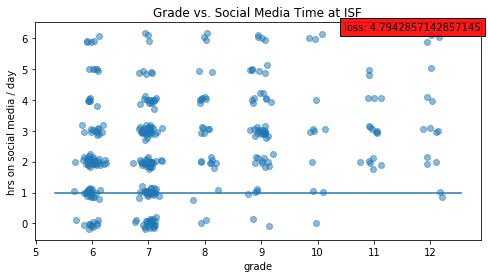

In [77]:
y_intercept = 1
slope = 0

fig, ax = plt.subplots(figsize=(8, 4))

ax.set_title("Grade vs. Social Media Time at ISF")
ax.set_xlabel(x_var_label)
ax.set_ylabel("hrs on social media / day")

draw(data_points_list, ax, jitter=True)

# create the line object
xmin, xmax = ax.get_xlim()
line, = ax.plot([xmin, xmax], [y_intercept + slope * xmin, y_intercept + slope * xmax])

line_loss = loss(slope, y_intercept, data_points_list)
loss_label = ax.text(1,1,'loss: {}'.format(line_loss), bbox=dict(facecolor='red', alpha=0.9), horizontalalignment='right', verticalalignment='top', transform=ax.transAxes)

min_slider_val = 0
max_slider_val = 2
mpld3.plugins.connect(fig, SliderView(line, loss_label, "y-intercept (b)", "b", min_slider_val, max_slider_val, ax.get_xlim(), callback_func="updateBSlider"))
mpld3.plugins.connect(fig, SliderView(line, loss_label, "slope (m)", "m", min_slider_val, max_slider_val, ax.get_xlim(), callback_func="updateMSlider"))

mpld3.save_html(fig, "regression_slider.html")

In [ ]:
ax = create_graph(x_var_label, y_var_label)
draw(data_points_list, ax, jitter=True)
m = 0
b = 1
draw_line(m, b, ax)
line_loss = loss(m, b, data_points_list)
add_loss(line_loss, ax)

**Note**: this notebook makes interactive calculation when slider position is changed, so you need to download this notebook to see any changes in plot.

## Complex example: beam deflection

When creating more interaction between Javascript and Python, things get easily quite complicated. Therefore one should consider using e.g. Backbone or similar to get more structured code in Javascript side. IPython notebook seems to be using Backbone internally already.

In the next example we add more inputs and use Backbone to handle syncronizing Python and Javascript. In this example we calculate the deflection line $v(x)$ for simple supported Euler Bernoulli beam and update visualization when user changes force location $x \in [0, 1]$. The formula for deflection $v(x)$ is 

\begin{equation}
v(x) = \frac{FL^2}{6EI}\left[ \frac{ab}{L^2}(L+b)\frac{x}{L} - b\left(\frac{x}{L}\right)^3 + \frac{1}{L^2}<x-a>^3 \right],
\end{equation}
where
\begin{equation}
<x-a>=\begin{cases}
0 & ,x<a\\
x-a & ,x\geq a
\end{cases}
\end{equation}
and $a$ is distance from left support, $a+b=L$.

More information about deflection: http://en.wikipedia.org/wiki/Deflection_%28engineering%29

First we define the template we use in our plugin:

In [ ]:
from IPython import display
display.HTML("""
<script type="text/template" id="tools-template">
    <h3>Tools</h3>
    <p><strong>Force location</strong></p>
    <input id="slider1" type="range" min="0" max="1" step="0.01" value="0.50" style="display: inline-block;">
    <label id="slider1label" for="slider1" style="display: inline-block; width: 40px;">0.50</label>
    <p><strong>Boundary conditions</strong></p>
    <select id="boundary_conditions">
          <option value="simple-simple">Simple support-Simple support</option>
          <option value="clamp-simple">Clamp-Simple support</option>
          <option value="clamp-clamp">Clamp-Clamp</option>
    </select>
    <p><strong>Young's modulus (GPa)</strong></p>
    <input id="young" type="number" value="210"/>
    <p><strong>Other options</strong></p>
    <div>
        <label><span style="vertical-align: middle">Use FEM to calculate deflection line?</span>
        <input id="useFEM" type="checkbox" style="vertical-align: middle" /></label>
    </div>
</script>
""")

Our plugin code comes next. Note that we have now Backbone model LineModel to handle Python-Javascript-interaction and Backbone views ToolsView and CanvasView to take care of visualization when data is changed.

Note that not all input elements are "connected" to the visualization, they are more like placeholders ready for your own coding experiments. They are not implemented on purpose to keep lines of code as low as possible. To get them work, modify ``this.notImplemented`` $\rightarrow$ ``this.modelChanged`` in ``initialize`` function and change ``var command = ... `` in ``modelChanged`` to pass more parameters to notebook server. Don't forget to change Python side function accordingly.

In [ ]:
class MyUserInterface(mpld3.plugins.PluginBase):
    """ Here we use Backbone to create more structured Javascript. """

    JAVASCRIPT = """

var LineModel = Backbone.Model.extend({

    initialize: function(options) {
        this.options = options || {};
        this.on("change:sliderPosition", this.modelChanged);
        this.on("change:boundaryCondition", this.notImplemented);
        this.on("change:youngsModulus", this.notImplemented);
        this.on("change:useFEM", this.notImplemented);
    },

    /**
        This example should be quite easy to extend to use more inputs. You
        just have to pass more model.get('...') things to kernel execute command below.
    */
    notImplemented: function(model) {
        alert("This function is not implemented in the example on purpose.");
    },

    /**
        Model changed, execute notebook kernel and update model data.
    */
    modelChanged: function(model) {
        var command = this.options.callback_func + "(" + model.get('sliderPosition') + ")";
        console.log("IPython kernel execute "+command);
        var callbacks = {
            'iopub' : {
                'output' : function(out) {
                    //console.log(out);
                    var res = null;
                    // if output is a print statement
                    if (out.msg_type == "stream"){
                      res = out.content.data;
                    }
                    // if output is a python object
                    else if(out.msg_type === "pyout"){
                      res = out.content.data["text/plain"];
                    }
                    // if output is a python error
                    else if(out.msg_type == "pyerr"){
                      res = out.content.ename + ": " + out.content.evalue;
                      alert(res);
                    }
                    // if output is something we haven't thought of
                    else{
                      res = "[out type not implemented]";
                      alert(res);
                    }
                    model.set("line", JSON.parse(res));
                }
            }
        };
        IPython.notebook.kernel.execute(command, callbacks, {silent:false});
    }

});


var ToolsView = Backbone.View.extend({

    /**
        This view renders toolbar with slider and other html elements.
    */
    initialize: function(options) {
        this.options = options || {};
        _.bindAll(this, 'render');
    },

    render: function() {
        var template = _.template($("#tools-template").html(), {});
        $(this.el).append(template);
        return this;
    },

    /**
        Listen event changes.
    */
    events: {
        "change #slider1": "changeSlider1",
        "change #boundary_conditions": "changeBoundaryConditions",
        "change #young": "changeModulus",
        "change #useFEM": "changeUseFEM"
    },

    changeSlider1: function(ev) {
        var sliderPosition = $(ev.currentTarget).val();
        this.model.set('sliderPosition', sliderPosition);
        $(this.el).find("#slider1label").text(parseFloat(sliderPosition).toFixed(2));
    },

    changeBoundaryConditions: function(ev) {
        this.model.set('boundaryCondition', $(ev.currentTarget).val());
    },

    changeModulus: function(ev) {
        this.model.set('youngsModulus', $(ev.currentTarget).val());
    },

    changeUseFEM: function(ev) {
        var isChecked = $(ev.currentTarget).is(":checked");
        this.model.set('useFEM', isChecked);
    }

});

var CanvasView = Backbone.View.extend({

    initialize: function(options) {
        this.options = options || {};
        this.line = mpld3.get_element(this.options.props.idline);
        _.bindAll(this, 'render');
        this.model.bind('change:line', this.render);
    },

    /**
        Update line when model changes, f.e. new data is calculated
        inside notebook and updated to Backbone model.
    */
    render: function() {
        this.line.elements().transition()
            .attr("d", this.line.datafunc(this.model.get('line')))
            .style("stroke", "black");
    }

});

// PLUGIN START

mpld3.register_plugin("myuserinterface", MyUserInterfacePlugin);
MyUserInterfacePlugin.prototype = Object.create(mpld3.Plugin.prototype);
MyUserInterfacePlugin.prototype.constructor = MyUserInterfacePlugin;
MyUserInterfacePlugin.prototype.requiredProps = ["idline", "callback_func"];
MyUserInterfacePlugin.prototype.defaultProps = {}

function MyUserInterfacePlugin(fig, props){
    mpld3.Plugin.call(this, fig, props);
};

MyUserInterfacePlugin.prototype.draw = function() {

    // Some hacking to get proper layout.
    var div = $("#" + this.fig.figid).attr("style", "border: 1px solid;");
    var figdiv = div.find("div");
    figdiv.attr("style", "display: inline;");

    // Create LineModel
    var lineModel = new LineModel({
      callback_func: this.props.callback_func
    });

    // Create tools view
    var myel = $('<div style="float: left; margin: 10px 30px;" id="tools"></div>');
    div.append(myel);
    var toolsView = new ToolsView({
        el: myel,
        model: lineModel
    });
    toolsView.render();

    // Create canvas view which updates line visualization when the model is changed
    var canvasView = new CanvasView({
        el: figdiv,
        model: lineModel,
        props: this.props
    });

};
"""

    def __init__(self, line, callback_func):
        self.dict_ = {"type": "myuserinterface",
                      "idline": mpld3.utils.get_id(line),
                      "callback_func": callback_func}

Next we do the actual calculation of the deflection using Python and display results:

In [ ]:
import numpy as np

L = 1.0
F = 3.0
E = 100.0
I = 0.1

def v_(x, a):
    b = L - a
    v = a*b/L**2*(L+b)*x/L - b*(x/L)**3
    if x-a > 0.0:
        v += 1.0/L**2*(x-a)**3
    v *= F*L**2/(6.0*E*I)
    return v

v = np.vectorize(v_)

def runCalculation(a):
    """ 
    """
    x = np.linspace(0, L, 500)
    y = -v(x, a)*1000.0
    return map(list, list(zip(list(x), list(y))))

fig, ax = plt.subplots(figsize=(8, 4))

t = np.linspace(0, 1, 200)
y = np.sin(t)
ax.set_xlabel('x [m]')
ax.set_ylabel('Deflection [mm]')
ax.set_title('Euler-Bernoulli beam deflection line')

# create the line object
initial_data = np.array(runCalculation(0.5))
line, = ax.plot(initial_data[:, 0], initial_data[:, 1], '-k', lw=3, alpha=0.5)
ax.plot([0.975, 1.025, 1.00, 0.975], [-1, -1, 0, -1], '-k', lw=1)
ax.plot([-0.025, 0.025, 0.000, -0.025], [-1, -1, 0, -1], '-k', lw=1)
ax.set_ylim(-10, 5)
ax.grid(lw=0.1, alpha=0.2)

mpld3.plugins.connect(fig, MyUserInterface(line, callback_func="runCalculation"))

**Note**: this notebook makes interactive calculation when slider position is changed, so you need to download this notebook to see any changes in plot.

**Note 2**: The line is updated only when force location is changed, but it should be trivial to extend this example use more tools. 